In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from scipy.cluster.vq import whiten
import gwpy
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
from gwpy.signal import filter_design
%matplotlib inline

In [2]:
DATADIR = "../input/g2net-gravitational-wave-detection"

In [3]:
train_df = pd.read_csv(f"{DATADIR}/training_labels.csv")
train_df

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
...,...,...
559995,ffff9a5645,1
559996,ffffab0c27,0
559997,ffffcf161a,1
559998,ffffd2c403,0


In [4]:
file_id = train_df.id[559998]
file_id

'ffffd2c403'

In [5]:
file = glob(f"{DATADIR}/train/{file_id[0]}/{file_id[1]}/{file_id[2]}/{file_id}.npy")

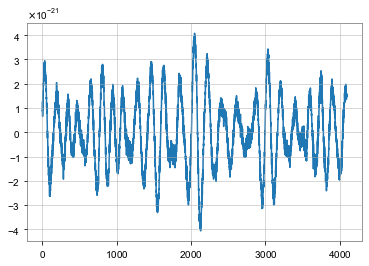

In [6]:
measurement = np.load(file[0])[2]
measurement2 = np.load(file[0])[1]
measurement3 = np.load(file[0])[0]
plt.plot(measurement)

In [7]:

# hdata = hdata.crop(*hdata.span.contract(1))
# hfilt = hfilt.crop(*hfilt.span.contract(1))

In [8]:
# hdata.span.contract(1)

NameError: name 'hdata' is not defined

In [9]:
ldata = TimeSeries(measurement2)
ldata.sample_rate = 2048
lfilt = ldata.filter(zpk, filtfilt=True)

NameError: name 'zpk' is not defined

In [ ]:
vdata = TimeSeries(measurement3)
vdata.sample_rate = 2048
vfilt = vdata.filter(zpk, filtfilt=True)

In [ ]:
def load_file(index):
    file_id = train_df.id[index]
    file_path = glob(f"{DATADIR}/train/{file_id[0]}/{file_id[1]}/{file_id[2]}/{file_id}.npy")
    file = np.load(file_path[0])
    return file

In [10]:
def plot_signal(index, x_lim = (0,2)):
    file = load_file(index)
    fig,ax = plt.subplots(figsize=(12,8),nrows=2,ncols=1)
    ax[0].set_title("LIGO-Handord strain data around something")
    ax[0].text(1.0, 1.01, "unfiltered Data", transform=ax1.transAxes, ha="right")
    ax[0].set_ylabel("Amplitude [Strain]", y = -0.2)
    ax[0].set_xlim(x_lim)
    ax[1].set_xlim(x_lim)
    ax[0].set_ylabel("time (s)")
    ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz', transform=ax2.transAxes, ha="right")
            
    for i in range(2):
        measurement = file[i]
        hdata = TimeSeries(measurement)
        hdata.sample_rate = 2048
        
        bp = filter_design.bandpass(50, 250, hdata.sample_rate)
        notches = [filter_design.notch(line, hdata.sample_rate) for line in (60, 120, 180)]
        zpk = filter_design.concatenate_zpks(bp, *notches)
        hfilt = hdata.filter(zpk, filtfilt=True)
        if i == 1:
            hfilt.shift("6.9ms")
            hfilt *= -1
        
        
        ax[0].plot(hdata)
        ax[1].plot(hfilt)
    plt.show()

In [11]:
plot_signal(4)

NameError: name 'load_file' is not defined

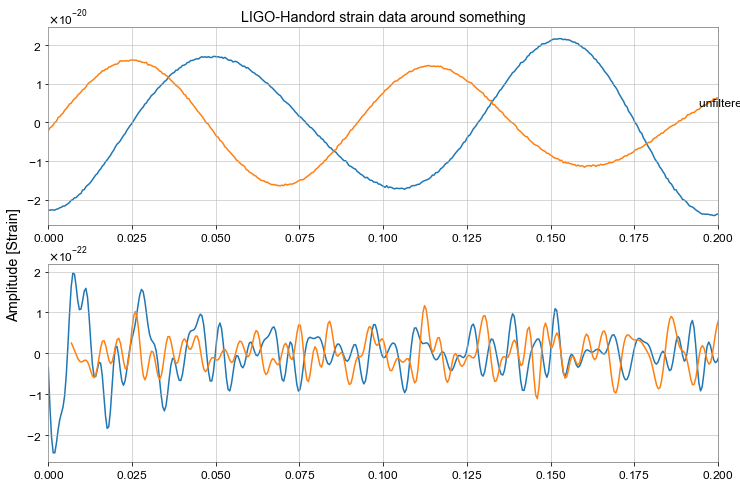

In [ ]:
plot_signal(4, (0, 0.2))

In [ ]:
train_df.head(20)

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
5,0000bb9f3e,1
6,0000c3b9c9,0
7,0000d61b7b,1
8,0001016d12,1
9,00010beb4a,1


In [ ]:
file = load_file(5)
lho = TimeSeries(file[0])
llo = TimeSeries(file[1])
lvo = TimeSeries(file[2])
for measurement in [lho, llo, lvo]:
    measurement.sample_rate = 2048
lhoasd = lho.asd()
lloasd = llo.asd()
lvoasd = lvo.asd()

(5e-24, 2e-23)

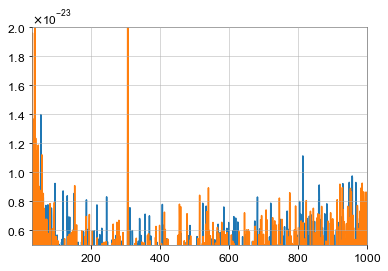

In [ ]:
plt.plot(lhoasd)
plt.plot(lloasd)
# plt.plot(lvoasd)
plt.xlim(30,1000)
plt.ylim(5e-24, 2e-23)

C:\Users\apist\anaconda3\envs\g2net-tf\lib\site-packages\gwpy\plot\plot.py:279: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


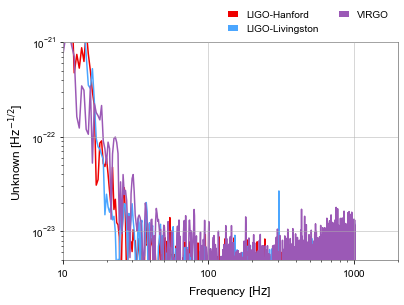

In [ ]:
plot = lhoasd.plot(label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax = plot.gca()
ax.plot(lloasd, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.plot(lvoasd, label='VIRGO', color='gwpy:virgo')
ax.set_xlim(10, 2000)
ax.set_ylim(5e-24, 1e-21)
ax.legend(frameon=False, bbox_to_anchor=(1., 1.), loc='lower right', ncol=2)
plot.show()

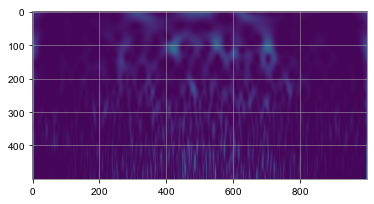

In [ ]:
power = lfilt.q_transform(qrange=(10,10), frange=(20, 512), fres = "<default>", logf=True)
power -= power.min()
power /= power.max()
plt.imshow(power * 255)

In [ ]:
mes_index

2

In [ ]:
def get_qtransform(file_index):
    file = load_file(file_index)
    tsfilts = []
    powers = []
    fig, axs = plt.subplots(figsize=(16,4), nrows =1, ncols = 3)
    print(train_df.target[file_index])
    for mes_index in range(3):
        ts = TimeSeries(file[mes_index])
        ts.sample_rate = 2048
        ts = ts.whiten()

        # Make filter
        tsfilt = ts
        bp = filter_design.bandpass(50, 250, hdata.sample_rate)
        notches = [filter_design.notch(line, hdata.sample_rate) for line in ((60, 120, 180) if mes_index != 2 else(50,100,150,200))]
        zpk = filter_design.concatenate_zpks(bp, *notches)

        tsfilt = ts.filter(zpk, filtfilt=True)
        if mes_index == 1:
            tsfilt *= -1

        power = tsfilt.q_transform(qrange=(10,10), frange=(30, 512), fres = "<default>", logf=True)
        power -= power.min()
        power /= power.max()
        power = power * 255.0
        power=power[250:750]
        powers.append(power)
        print(power.shape)
        
        axs[mes_index].imshow(power)
        tsfilts.append(tsfilt)
    return np.transpose(np.array(powers, dtype=np.uint8), (2,1,0))
        #     for ts in tsfilts:
#         axs[1,0].plot(ts)
#     fig.show()

0
(500, 500)
(500, 500)
(500, 500)


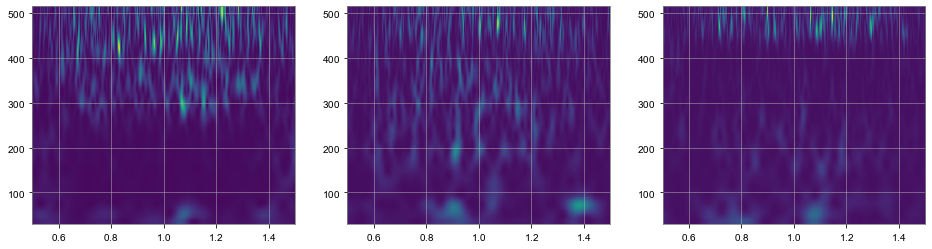

In [ ]:
powers = get_qtransform(6)

0
(500, 500)
(500, 500)
(500, 500)
255


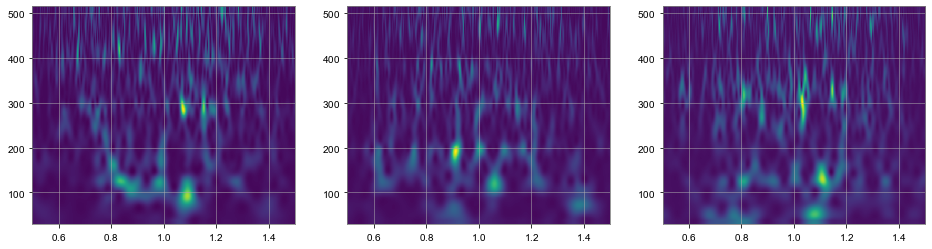

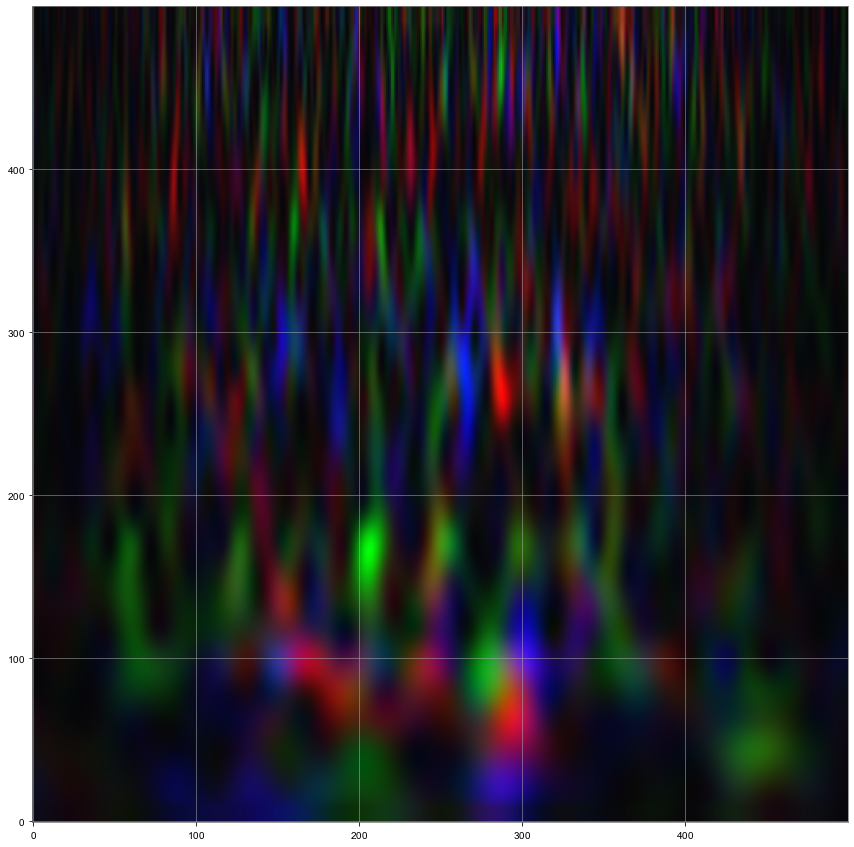

In [ ]:
powers = get_qtransform(6)
print(powers.max())
plt.figure(figsize=(15,15))
plt.imshow(powers)
plt.gca().invert_yaxis()


In [ ]:

powers.max()

74.84908

In [ ]:
train_df.target[10]

0

<class 'numpy.ndarray'>


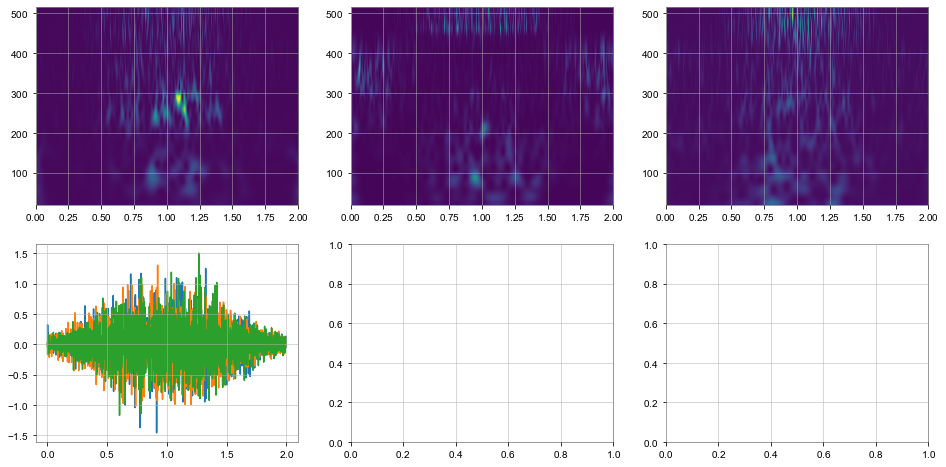

In [ ]:
get_qtransform(1)

<class 'numpy.ndarray'>


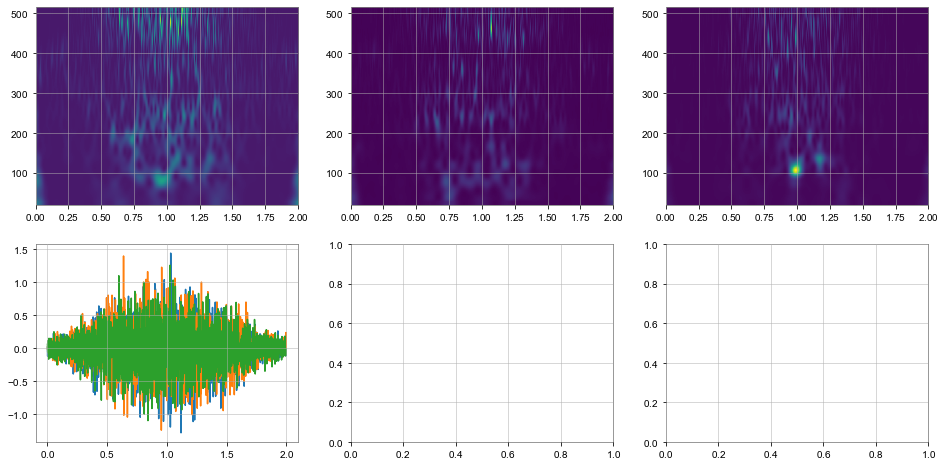

In [ ]:
get_qtransform(5)

In [ ]:
train_df.head(10)

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
5,0000bb9f3e,1
6,0000c3b9c9,0
7,0000d61b7b,1
8,0001016d12,1
9,00010beb4a,1


1
(500, 500)
(500, 500)
(500, 500)


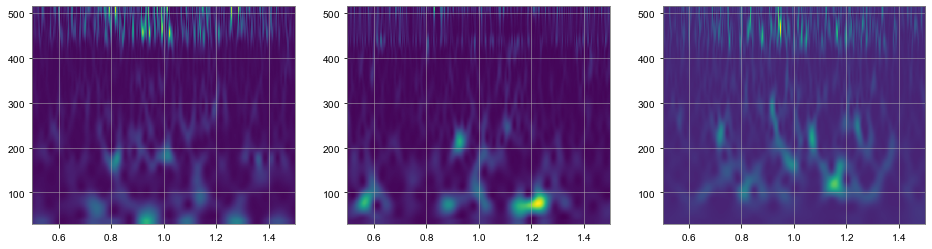

0
(500, 500)
(500, 500)
(500, 500)


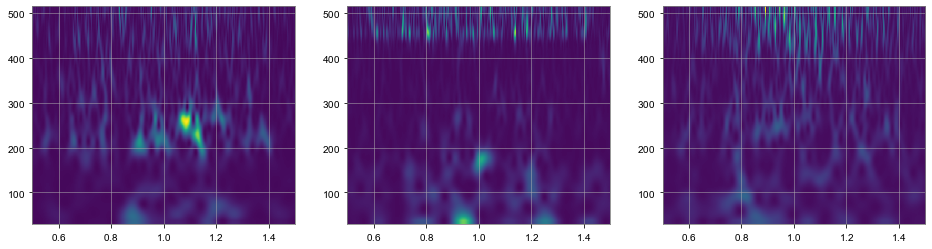

0
(500, 500)
(500, 500)
(500, 500)


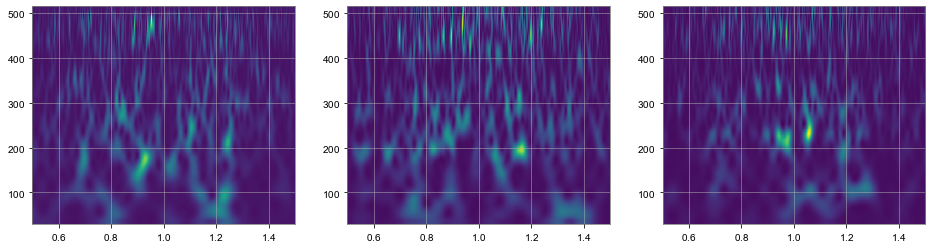

0
(500, 500)
(500, 500)
(500, 500)


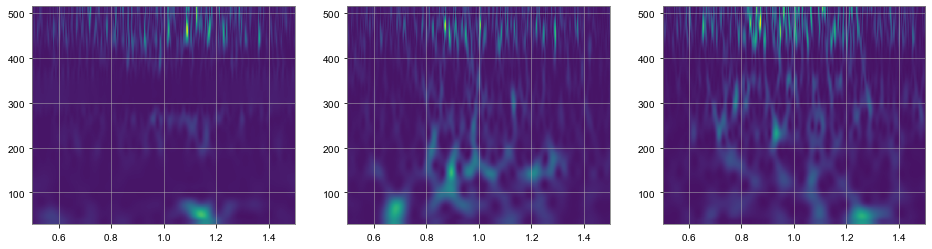

1
(500, 500)
(500, 500)
(500, 500)


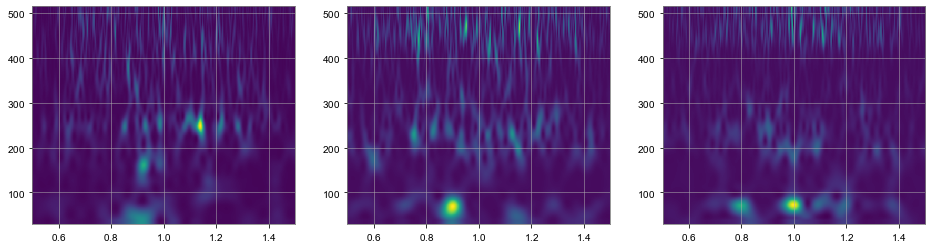

1
(500, 500)
(500, 500)
(500, 500)


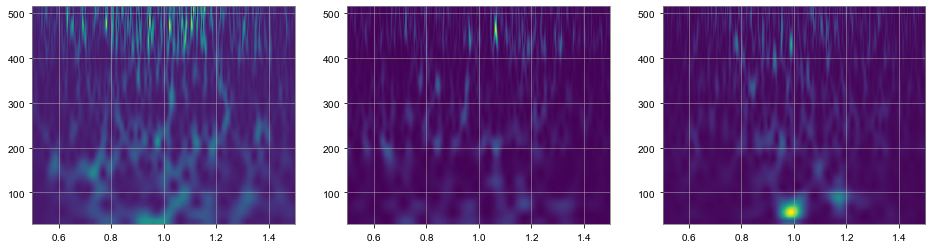

0
(500, 500)
(500, 500)
(500, 500)


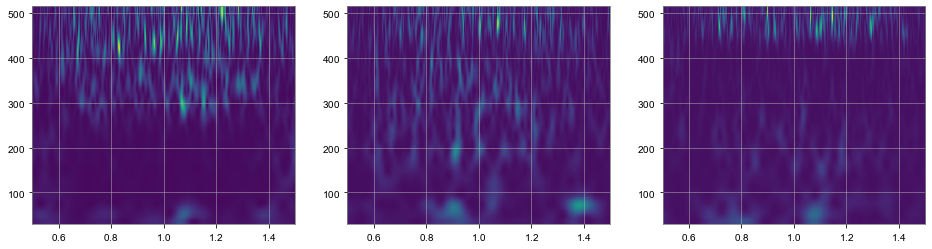

1
(500, 500)
(500, 500)
(500, 500)


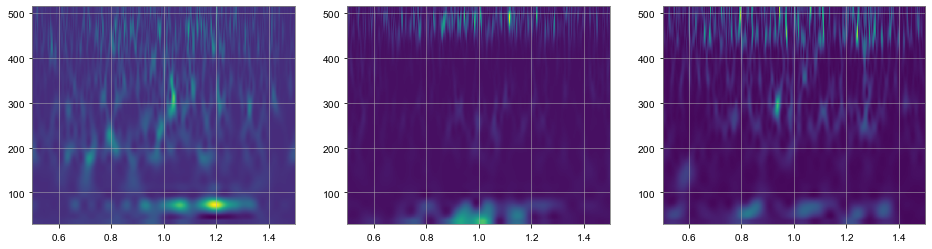

1
(500, 500)
(500, 500)
(500, 500)


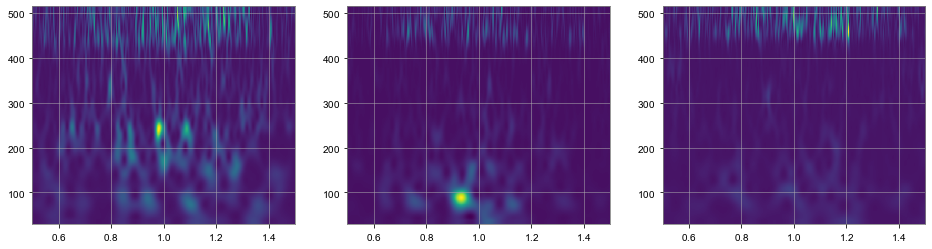

1
(500, 500)
(500, 500)
(500, 500)


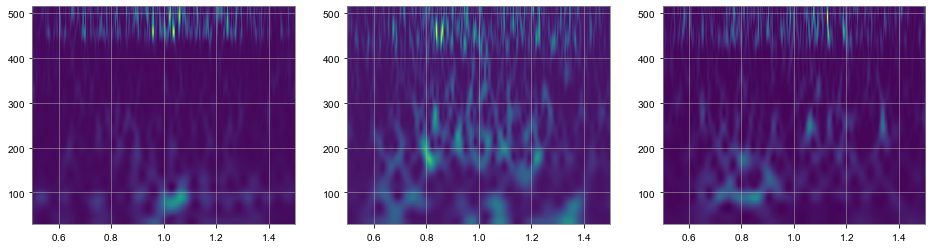

In [ ]:
for i in range(10):
    get_qtransform(i)
    plt.show()